This notebook is designed to show the properties of the Lane-Emden equation for interger values of n. The equation is solved by a 4th order Runge-Kutta solver, while the roots of the Lane-Emden functions where determined using a Newton-Raphson solver

In the first block, we import the required libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML, display, Math
import tabulate
import warnings

We define the classes necessary to carry out the Runge-Kutta 4th order integration. runkutt is the integrater and the g function will update the function and the first derivative

In [2]:
def runkutt(y,t,dt,n):
#The method implemented is the one described in An Introduction to Computational Physics, 2nd Edition
# by Tao Pang    
    c1 = np.zeros(2)
    c2 = np.zeros(2)
    c3 = np.zeros(2)
    c4 = np.zeros(2)
  
    c1 = g(y,t,n)
    
    c2 = y + dt*c1/2
    c2 = g(c2,t+dt/2,n)
    
    c3 = y + dt*c2/2
    c3 = g(c3,t+dt/2,n)
    
    c4 = y + dt*c3/2 
    c4 = g(c4,t+dt/2,n)
    
    return y + dt*(c1 + 2*(c2+c3) +c4)/6
    

def g(y,t,n):
# updates the function and the first derivative    
    v = np.zeros(2)
    
    v[0] = -y[1]/t**2
    v[1] = (y[0]**n)*t**2
    
    return v

The Newton-Raphson method is used to calculate the 1st roots of the polytrope

In [3]:
def newton_raphson(x,y,dy,x0,j):
# since we on't have an explicit function, we need to interpolate the data at every new "root"
# until convergence. 
    h = y[j]/dy[j]
    while abs(h) >=1e-10:
        x0 -= h
        y0  = np.interp(x0,x,y)
        dy0 = np.interp(x0,x,dy)
        h   = y0/dy0
    return x0

This block calls the Runge-Kutta solver applied to the Lane-Embden equations for integer index from 0 to 5.

In [4]:
warnings.filterwarnings("ignore")
m    = 10000
dt   = 20/m
table = np.empty((5,3))
poly_temp = np.empty((m,6))
dim_less_rad = np.zeros(m)

roots = np.empty(5)
d_theta_1 = np.empty(5)
for i in range(m):
    dim_less_rad[i] = dt*(i+1)
for n in range(0,6):
        
    y1 = np.zeros(m)
    y2 = np.zeros(m)
    
    y  = np.zeros(2)
    y[0] = 1
    y[1] = 0
    
    y1[0] = y[0]
    y2[0] = y[1]
        
    for i in range (m):
        
        y     = runkutt(y,dim_less_rad[i],dt,n)
        y1[i] = y[0]
        y2[i] = y[1]
        poly_temp[i,n] = y1[i]
            
    
    if n!=5:
       dy = np.gradient(y1,dt)          
       i = 0
       for i in range(m):
           if y1[i] < 0:
              break            

       t0 = dim_less_rad[i-1]
       t1 = newton_raphson(dim_less_rad,y1,dy,t0,i-1)
       roots[n] = t1
       d_theta_1[n] = abs(np.interp(t1,dim_less_rad,dy))      
       table[n] = [n,t1,d_theta_1[n]]

We graph the solutions of the Lane-Emden equation, with the roots marked, and the important properties tabulated

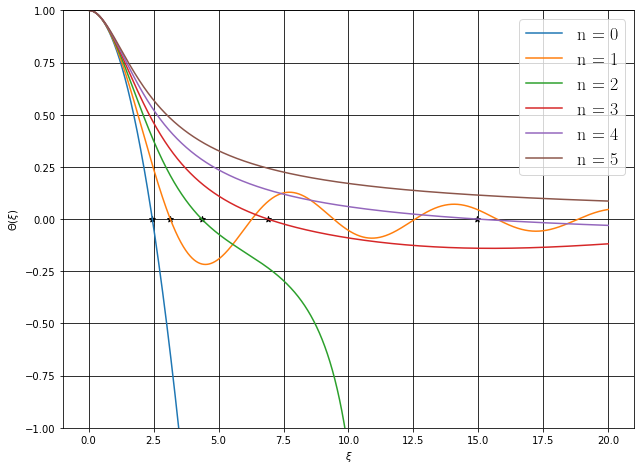

<IPython.core.display.Math object>

0,2.44816,0.816496
1,3.13976,0.318476
2,4.35017,0.127342
3,6.89194,0.0424747
4,14.9565,0.00803214


In [5]:
plt.figure(figsize=(10.24,7.68))
plt.xlabel(r'$\xi$')
plt.ylabel(r'$\Theta(\xi)$')
plt.ylim([-1,1])
plt.rc('text', usetex=True)
plt.rc('font', family = 'serif')
plt.rcParams['font.size']=18
plt.grid(color = 'black')
roots_ordinate = np.zeros(np.size(roots)) 
for i in range(0,6):
    plt.plot(dim_less_rad,poly_temp[:,i],label = 'n = '+str(i))
plt.scatter(roots,roots_ordinate,marker='*',color='black')

plt.legend()
plt.show()

display(Math(r'n  \;\;\;\;\;  \xi_{1}   \;\;\;\;\; -\frac{d\theta}{d\xi}\Bigr|_{\xi=\xi_{1}}'))
display(HTML(tabulate.tabulate(table, tablefmt='html')))

To extract the measurable physics from the solutions, we need to specify the central pressure and density, as well the K factor (units are in cgs). Since the star actually reaches it's maximal radius at the 1st root of the Lane_Emden equation

In [15]:
n = 3 #polytropic index [select integer from 0 to 5]
M = 1 #total mass in solar masses
R = 0.02 #total radius in terms of solar radius

m_sun = 1.989e+33 #grams
r_sun = 6.957e+10 #cm
G = 6.67408e-8    #dyn.(cm/g)^2

#calculating K
term1 = G/(n+1)
term2 = np.power(M*m_sun,1-1/n)*np.power(R*r_sun,-1+3/n)
term3 = 4*np.pi
term4 = np.power(roots[n],n+1)*np.power(d_theta_1[n],n-1)

K = term1*term2*np.power(term3/term4,1/n)

#Calculating the central pressure
term1 = 8.952e+14*np.power(M,2)*np.power(R,-4)
term2 = (n+1)*np.power(d_theta_1[n],2)
P_c   = term1/term2 #dyne/cm^2
#Calculating central density
rho_c = np.power(P_c/K,n/(n+1))
#length scale
term1 = (n+1)*P_c
term2 = 4*np.pi*G*np.power(rho_c,2)
alpha = np.sqrt(term1/term2)

#solve for the extent to cut off the arrays
limit = np.where(np.abs(dim_less_rad-roots[n])<1e-2)[0]

dummy_1 = dim_less_rad[0:limit[0]]
dummy_2 = poly_temp[0:limit[0],n+1]
dummy_3 = poly_temp[0:limit[0],n]

dm_lss_rd = dummy_1
pl_tmp = dummy_2
pl_tmp_dense = dummy_3
pl_tmp_grad = np.gradient(pl_tmp_dense,dt)
d_term = np.power(dm_lss_rd,2)*abs(np.interp(dm_lss_rd,dm_lss_rd,pl_tmp_grad))
#calculating the radius, denisty, mass, and pressure using the Polytropic temperature
rad = alpha*dm_lss_rd
P = P_c*pl_tmp
rho = rho_c*pl_tmp_dense
mass = 4*np.pi*np.power(alpha,3)*rho_c*d_term

#for Meyer
data = np.column_stack([rad,mass])
np.savetxt('rad_mass.txt',data)


TypeError: _column_stack_dispatcher() takes 1 positional argument but 2 were given

Plotting the good stuff

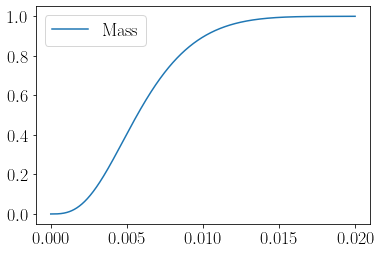

In [14]:
plt.figure()
plt.plot(rad/r_sun,mass/m_sun,label='Mass')

plt.legend()
plt.show()

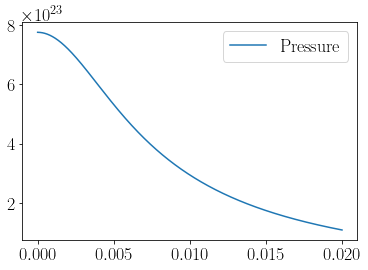

In [12]:
plt.figure()
plt.plot(rad/r_sun,P,label='Pressure')

plt.legend()
plt.show()

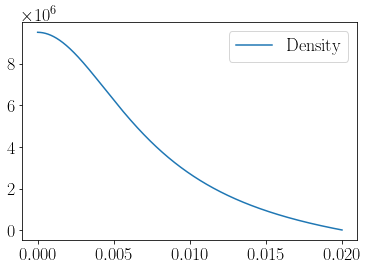

In [13]:
plt.figure()
plt.plot(rad/r_sun,rho,label='Density')
plt.legend()
plt.show()